# Introduction

Seattle is a seaport city on the West Coast of the United States. It is the seat of King County, Washington. Seattle is the largest city in both the state of Washington and the Pacific Northwest region of North America.

Seattle's economy is driven by a mix of older industrial companies, and "new economy" Internet and technology companies, service, design, and clean technology companies.

The City of Seattle  goal is to reduce total core greenhouse gas emissions 58% by 2030 and become carbon neutral by 2050 (https://www.seattle.gov/environment/environmental-progress/climate-change).

This project take a look at 2015 and 2016 data from non-residentials building, then aim to predict electricity consumption and greenhouse gas emissions.

This is a dataset hosted by the City of Seattle. The city has an open data platform :

* https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m

* https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Librairies

In [ ]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
import json
import urllib
import requests
plt.style.use('fivethirtyeight')

# Loading data

In [ ]:
# lorading data
url = 'https://data.seattle.gov/resource/h7rm-fz6m.json'
r = requests.get(url)
data_2015 = pd.DataFrame(r.json())

# taking a quick first look at 2015 data 
data_2015.head(5)

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,taxparcelidentificationnumber,location,councildistrictcode,neighborhood,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,energystarscore,siteeui_kbtu_sf,siteeuiwn_kbtu_sf,sourceeui_kbtu_sf,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,otherfueluse_kbtu,ghgemissions_metrictonsco2e,ghgemissionsintensity_kgco2e_ft2,defaultdata,compliancestatus,:@computed_region_ru88_fbhk,:@computed_region_kuhn_3gp2,:@computed_region_q256_3sug,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,outlier,yearsenergystarcertified,:@computed_region_2day_rhn5,:@computed_region_cyqu_gs94,comment
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,65,78.90,80.30,173.50,175.10,6981428,7097539,2023032,1080307,3686160,12724,1272388,0,249.43,2.64,No,Compliant,14,31,18081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,51,94.40,99.00,191.30,195.20,8354235,8765788,0,1144563,3905411,44490,4448985,0,263.51,2.38,No,Compliant,14,31,18081,Parking,15064,Restaurant,4622,NaN,NaN,NaN,NaN,NaN
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243,18,96.60,99.70,242.70,246.50,73130656,75506272,19660404,14583930,49762435,37099,3709900,0,2061.48,1.92,Yes,Compliant,56,31,18081,Parking,100000,Swimming Pool,0,NaN,NaN,NaN,NaN,NaN
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10,61320,0,61320,Hotel,Hotel,61320,1,460.40,462.50,636.30,643.20,28229320,28363444,23458518,811521,2769023,20019,2001894,0,1936.34,31.38,No,Compliant,56,31,18081,NaN,NaN,NaN,NaN,High Outlier,NaN,NaN,NaN,NaN
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445,67,120.10,122.10,228.80,227.10,14829099,15078243,0,1777841,6066245,87631,8763105,0,507.7,4.02,No,Compliant,56,31,19576,Parking,68009,Swimming Pool,0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# loading data
url = 'https://data.seattle.gov/resource/2bpz-gwpy.json'
r = requests.get(url)
data_2016 = pd.DataFrame(r.json())

# Lokking at 2016 data for comparison.
data_2016.head(5)

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,city,state,zipcode,taxparcelidentificationnumber,councildistrictcode,neighborhood,latitude,longitude,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,energystarscore,siteeui_kbtu_sf,siteeuiwn_kbtu_sf,sourceeui_kbtu_sf,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,defaultdata,compliancestatus,totalghgemissions,ghgemissionsintensity,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,yearsenergystarcertified,outlier
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101,0659000030,7,DOWNTOWN,47.6122,-122.33799,1927,1,12,88434,0,88434,Hotel,Hotel,88434,60,81.69999695,84.30000305,182.5,189,7226362.5,7456910,2003882,1156514.25,3946027,12764.5293,1276453,False,Compliant,249.98,2.83,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,61,94.80000305,97.90000153,176.1000061,179.3999939,8387933,8664479,0,950425.1875,3242851,51450.81641,5145082,False,Compliant,295.86,2.86,Parking,15064,Restaurant,4622,NaN,NaN
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101,0659000475,7,DOWNTOWN,47.61393,-122.3381,1969,1,41,956110,196718,759392,Hotel,Hotel,756493,43,96,97.69999695,241.8999939,244.1000061,72587024,73937112,21566554,14515435,49526664,14938,1493800,False,Compliant,2089.28,2.19,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,61320,0,61320,Hotel,Hotel,61320,56,110.8000031,113.3000031,216.1999969,224,6794584,6946800.5,2214446.25,811525.3125,2768924,18112.13086,1811213,False,Compliant,286.43,4.67,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445,75,114.8000031,118.6999969,211.3999939,215.6000061,14172606,14656503,0,1573448.625,5368607,88039.98438,8803998,False,Compliant,505.01,2.88,Parking,68009,Swimming Pool,0,NaN,NaN


In [ ]:
# checking on shape form both dataframe
print("shape 2015: " + str(data_2015.shape))
print("shape 2016: " + str(data_2016.shape))

shape 2015: (1000, 47)
shape 2016: (1000, 45)


* Not the same number of columns.

In [ ]:
print("nan 2015: " + str(data_2015.isna().sum().sum()))
print("nan 2016: " + str(data_2016.isna().sum().sum()))

nan 2015: 7708
nan 2016: 4622


* Important volume of Na's

# Columns

In [ ]:
# looking for difference in columns

## listing columns for both df
col_2015 = data_2015.columns
col_2016 = data_2016.columns

## Finding missing cols
list_difference1 = [item for item in col_2015 if item not in col_2016]
list_difference2 = [item for item in col_2016 if item not in col_2015]

## comparing lists
set(list_difference1) ^ set(list_difference2)

{':@computed_region_2day_rhn5',
 ':@computed_region_cyqu_gs94',
 ':@computed_region_kuhn_3gp2',
 ':@computed_region_q256_3sug',
 ':@computed_region_ru88_fbhk',
 'address',
 'city',
 'comment',
 'ghgemissions_metrictonsco2e',
 'ghgemissionsintensity',
 'ghgemissionsintensity_kgco2e_ft2',
 'latitude',
 'location',
 'longitude',
 'osebuildingid',
 'otherfueluse_kbtu',
 'seattlebuildingid',
 'secondlargestpropertyuse',
 'secondlargestpropertyusetypegfa',
 'state',
 'totalghgemissions',
 'zipcode'}

* 12 columns not included in both dataframe -> need corrections or dropping

# NonResidential Buildings

In [ ]:
# Checking on building type
print(data_2015["buildingtype"].unique())
print(data_2016["buildingtype"].unique())

['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Multifamily LR (1-4)' 'Campus'
 'Multifamily HR (10+)']
['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)']


In [ ]:
# Keeping NonResidential / schools only

nr = ['SPS-District K-12',"NonResidential","Nonresidential COS"]

data_2015 = data_2015[data_2015["buildingtype"].isin(nr)]
data_2016 = data_2016[data_2016["buildingtype"].isin(nr)]

# City

City is not in 2015 data.

In [ ]:
data_2016["city"].unique()

array(['Seattle'], dtype=object)

* 2016 city is only Seattle -> drop

In [ ]:
# Dropping city
data_2016.drop("city", axis = 1, inplace=True)

# Longitude / Latitude

2015 location need reformating to acces latitude and longitude like in 2016 data.

In [ ]:
data_2015["location"]

0      {'latitude': '47.61219025', 'longitude': '-122...
1      {'latitude': '47.61310583', 'longitude': '-122...
2      {'latitude': '47.61334897', 'longitude': '-122...
3      {'latitude': '47.61421585', 'longitude': '-122...
4      {'latitude': '47.6137544', 'longitude': '-122....
                             ...                        
995    {'latitude': '47.56485289', 'longitude': '-122...
996    {'latitude': '47.56502533', 'longitude': '-122...
997    {'latitude': '47.56334562', 'longitude': '-122...
998    {'latitude': '47.56221008', 'longitude': '-122...
999    {'latitude': '47.56147766', 'longitude': '-122...
Name: location, Length: 747, dtype: object

In [ ]:
# converting type
temp = data_2015["location"].apply(pd.Series)
temp.drop("human_address", axis = 1, inplace=True)

# Concat with 2015 df
data_2015 = pd.concat([data_2015,temp], axis = 1)

# Looking if values are normal
data_2015[["latitude",	"longitude"]]

,latitude,longitude
0,47.61219025,-122.33799744
1,47.61310583,-122.33335756
2,47.61334897,-122.33769944
3,47.61421585,-122.33660889
4,47.6137544,-122.3409238
...,...,...
995,47.56485289,-122.38521848
996,47.56502533,-122.38456726
997,47.56334562,-122.38494153
998,47.56221008,-122.38638306


In [ ]:
data_2016.head(5)

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,state,zipcode,taxparcelidentificationnumber,councildistrictcode,neighborhood,latitude,longitude,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,energystarscore,siteeui_kbtu_sf,siteeuiwn_kbtu_sf,sourceeui_kbtu_sf,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,defaultdata,compliancestatus,totalghgemissions,ghgemissionsintensity,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,yearsenergystarcertified,outlier
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,WA,98101,0659000030,7,DOWNTOWN,47.6122,-122.33799,1927,1,12,88434,0,88434,Hotel,Hotel,88434,60,81.69999695,84.30000305,182.5,189,7226362.5,7456910,2003882,1156514.25,3946027,12764.5293,1276453,False,Compliant,249.98,2.83,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,WA,98101,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,61,94.80000305,97.90000153,176.1000061,179.3999939,8387933,8664479,0,950425.1875,3242851,51450.81641,5145082,False,Compliant,295.86,2.86,Parking,15064,Restaurant,4622,NaN,NaN
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,WA,98101,0659000475,7,DOWNTOWN,47.61393,-122.3381,1969,1,41,956110,196718,759392,Hotel,Hotel,756493,43,96,97.69999695,241.8999939,244.1000061,72587024,73937112,21566554,14515435,49526664,14938,1493800,False,Compliant,2089.28,2.19,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,WA,98101,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1,10,61320,0,61320,Hotel,Hotel,61320,56,110.8000031,113.3000031,216.1999969,224,6794584,6946800.5,2214446.25,811525.3125,2768924,18112.13086,1811213,False,Compliant,286.43,4.67,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,WA,98121,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445,75,114.8000031,118.6999969,211.3999939,215.6000061,14172606,14656503,0,1573448.625,5368607,88039.98438,8803998,False,Compliant,505.01,2.88,Parking,68009,Swimming Pool,0,NaN,NaN


# ID

In [ ]:
# renaming columns for stats testing and modeling
data_2016 = data_2016.rename(columns = {"osebuildingid":"seattlebuildingid"})

# CO2 : 
* 2015 = ghgemissions_metrictonsco2e
* 2016 = totalghgemissions

In [ ]:
# renaming columns for stats testing and modeling
data_2015 = data_2015.rename(columns = {"ghgemissions_metrictonsco2e":"totalghgemissions"})

# Energy
* 2015 = siteenergyuse_kbtu
* 2016 = siteenergyuse_kbtu


# Use type

In [ ]:
col = data_2015.filter(regex=("largestproperty")).columns
col

Index(['largestpropertyusetype', 'largestpropertyusetypegfa',
       'secondlargestpropertyusetype', 'secondlargestpropertyusetypegfa',
       'thirdlargestpropertyusetype', 'thirdlargestpropertyusetypegfa'],
      dtype='object')

In [ ]:
col = data_2016.filter(regex=("largestproperty")).columns
col

Index(['largestpropertyusetype', 'largestpropertyusetypegfa',
       'secondlargestpropertyusetype', 'secondlargestpropertyuse',
       'thirdlargestpropertyusetype', 'thirdlargestpropertyusetypegfa'],
      dtype='object')

* second largest use and gfa have different names.

In [ ]:
# renaming columns for stats testing and modeling
data_2016 = data_2016.rename(columns = {"secondlargestpropertyuse":"secondlargestpropertyusetypegfa"})

data_2016 = data_2016.rename(columns = {"secondlargestpropertyuse":"secondlargestpropertyusetype"})

In [ ]:
data_2016.columns

Index(['seattlebuildingid', 'datayear', 'buildingtype', 'primarypropertytype',
       'propertyname', 'address', 'state', 'zipcode',
       'taxparcelidentificationnumber', 'councildistrictcode', 'neighborhood',
       'latitude', 'longitude', 'yearbuilt', 'numberofbuildings',
       'numberoffloors', 'propertygfatotal', 'propertygfaparking',
       'propertygfabuilding_s', 'listofallpropertyusetypes',
       'largestpropertyusetype', 'largestpropertyusetypegfa',
       'energystarscore', 'siteeui_kbtu_sf', 'siteeuiwn_kbtu_sf',
       'sourceeui_kbtu_sf', 'sourceeuiwn_kbtu_sf', 'siteenergyuse_kbtu',
       'siteenergyusewn_kbtu', 'steamuse_kbtu', 'electricity_kwh',
       'electricity_kbtu', 'naturalgas_therms', 'naturalgas_kbtu',
       'defaultdata', 'compliancestatus', 'totalghgemissions',
       'ghgemissionsintensity', 'secondlargestpropertyusetype',
       'secondlargestpropertyusetypegfa', 'thirdlargestpropertyusetype',
       'thirdlargestpropertyusetypegfa', 'yearsenergystarce

In [ ]:
data_2015.columns

Index(['seattlebuildingid', 'datayear', 'buildingtype', 'primarypropertytype',
       'propertyname', 'taxparcelidentificationnumber', 'location',
       'councildistrictcode', 'neighborhood', 'yearbuilt', 'numberofbuildings',
       'numberoffloors', 'propertygfatotal', 'propertygfaparking',
       'propertygfabuilding_s', 'listofallpropertyusetypes',
       'largestpropertyusetype', 'largestpropertyusetypegfa',
       'energystarscore', 'siteeui_kbtu_sf', 'siteeuiwn_kbtu_sf',
       'sourceeui_kbtu_sf', 'sourceeuiwn_kbtu_sf', 'siteenergyuse_kbtu',
       'siteenergyusewn_kbtu', 'steamuse_kbtu', 'electricity_kwh',
       'electricity_kbtu', 'naturalgas_therms', 'naturalgas_kbtu',
       'otherfueluse_kbtu', 'totalghgemissions',
       'ghgemissionsintensity_kgco2e_ft2', 'defaultdata', 'compliancestatus',
       ':@computed_region_ru88_fbhk', ':@computed_region_kuhn_3gp2',
       ':@computed_region_q256_3sug', 'secondlargestpropertyusetype',
       'secondlargestpropertyusetypegfa', 't

# Merge

In [ ]:
## listing columns for both df
col_2015 = data_2015.columns
col_2016 = data_2016.columns

# droppping cols not in both df
to_drop = set(col_2015) ^ set(col_2016)

for col in to_drop:
  if col in data_2015.columns :
    data_2015.drop(col, axis = 1 , inplace=True)

for col in to_drop:
  if col in data_2016.columns :
    data_2016.drop(col, axis = 1 , inplace=True)

In [ ]:
# checking for errors
col_2015 = data_2015.columns
col_2016 = data_2016.columns
set(col_2015) ^ set(col_2016)

set()

In [ ]:
# checking for errors
print("shape 2015: " + str(data_2015.shape))
print("shape 2016: " + str(data_2016.shape))

shape 2015: (747, 40)
shape 2016: (743, 40)


In [ ]:
# Concat 2015 and 2016
data = pd.concat([data_2015, data_2016])

In [ ]:
data.head()

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,taxparcelidentificationnumber,councildistrictcode,neighborhood,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,energystarscore,siteeui_kbtu_sf,siteeuiwn_kbtu_sf,sourceeui_kbtu_sf,sourceeuiwn_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,steamuse_kbtu,electricity_kwh,electricity_kbtu,naturalgas_therms,naturalgas_kbtu,totalghgemissions,defaultdata,compliancestatus,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,outlier,yearsenergystarcertified,latitude,longitude
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12,88434,0,88434,Hotel,Hotel,88434,65,78.90,80.30,173.50,175.10,6981428,7097539,2023032,1080307,3686160,12724,1272388,249.43,No,Compliant,NaN,NaN,NaN,NaN,NaN,NaN,47.61219025,-122.33799744
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880,51,94.40,99.00,191.30,195.20,8354235,8765788,0,1144563,3905411,44490,4448985,263.51,No,Compliant,Parking,15064,Restaurant,4622,NaN,NaN,47.61310583,-122.33335756
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243,18,96.60,99.70,242.70,246.50,73130656,75506272,19660404,14583930,49762435,37099,3709900,2061.48,Yes,Compliant,Parking,100000,Swimming Pool,0,NaN,NaN,47.61334897,-122.33769944
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10,61320,0,61320,Hotel,Hotel,61320,1,460.40,462.50,636.30,643.20,28229320,28363444,23458518,811521,2769023,20019,2001894,1936.34,No,Compliant,NaN,NaN,NaN,NaN,High Outlier,NaN,47.61421585,-122.33660889
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445,67,120.10,122.10,228.80,227.10,14829099,15078243,0,1777841,6066245,87631,8763105,507.7,No,Compliant,Parking,68009,Swimming Pool,0,NaN,NaN,47.6137544,-122.3409238


In [ ]:
# defining cols to keep
target = ["totalghgemissions","siteenergyuse_kbtu","energystarscore"]

col_exp = ['seattlebuildingid', 'datayear', 'buildingtype', 'primarypropertytype',
       'propertyname','councildistrictcode',
       'yearbuilt', 'numberofbuildings', 'numberoffloors',
       'propertygfatotal', 'propertygfaparking',"propertygfabuilding_s",'latitude', 'longitude','outlier']

col_use = data.filter(regex=("largestproperty")).columns

# selecting cols
data = pd.concat([data[col_exp],data[col_use],data[target]], axis = 1)

# duplicates

In [ ]:
duplicates = data.duplicated(subset = ["seattlebuildingid"])
len(data[duplicates])

734

* 734 building are in both original datasets.

In [ ]:
# ordering to keep highest emissions if duplicated
data.sort_values("totalghgemissions",ascending=False, inplace=True)

# dropping duplicates
data.drop_duplicates(subset="seattlebuildingid", keep="first", inplace=True)

#checking for duplicates
duplicates = data.duplicated(subset = ["seattlebuildingid"])
len(data[duplicates])

0

# Types

In [ ]:
# Checking data types

col = ['numberofbuildings', 'numberoffloors', 'propertygfatotal',
       'propertygfaparking', 'propertygfabuilding_s',
       'largestpropertyusetypegfa',
       'secondlargestpropertyusetypegfa',
       'thirdlargestpropertyusetypegfa',
       'totalghgemissions', 'siteenergyuse_kbtu']

data[col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 463 to 987
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   numberofbuildings                756 non-null    object
 1   numberoffloors                   756 non-null    object
 2   propertygfatotal                 756 non-null    object
 3   propertygfaparking               756 non-null    object
 4   propertygfabuilding_s            756 non-null    object
 5   largestpropertyusetypegfa        736 non-null    object
 6   secondlargestpropertyusetypegfa  421 non-null    object
 7   thirdlargestpropertyusetypegfa   189 non-null    object
 8   totalghgemissions                756 non-null    object
 9   siteenergyuse_kbtu               756 non-null    object
dtypes: object(10)
memory usage: 65.0+ KB


In [ ]:
# converting types

sf = ["numberofbuildings","numberoffloors"]

for var in sf :
  data[var] = data[var].astype("int")

sf = ["propertygfatotal" , "propertygfaparking" , "propertygfabuilding_s",
      "largestpropertyusetypegfa" , "secondlargestpropertyusetypegfa" ,"thirdlargestpropertyusetypegfa",
      "totalghgemissions","siteenergyuse_kbtu"]

for var in sf :
  data[var] = data[var].astype("float")

In [ ]:
data[col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 463 to 987
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   numberofbuildings                756 non-null    int64  
 1   numberoffloors                   756 non-null    int64  
 2   propertygfatotal                 756 non-null    float64
 3   propertygfaparking               756 non-null    float64
 4   propertygfabuilding_s            756 non-null    float64
 5   largestpropertyusetypegfa        736 non-null    float64
 6   secondlargestpropertyusetypegfa  421 non-null    float64
 7   thirdlargestpropertyusetypegfa   189 non-null    float64
 8   totalghgemissions                756 non-null    float64
 9   siteenergyuse_kbtu               756 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 65.0 KB


# Nb of Building

In [ ]:
data[data["numberofbuildings"].isna()]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore


In [ ]:
len(data[data["numberofbuildings"]==0])

10

* 10 building with 0 buildings.....

In [ ]:
# Minning in 0 building 
mask1 = (data["numberofbuildings"]==0) & (data["secondlargestpropertyusetype"].isna())
mask2 = (data["thirdlargestpropertyusetype"].isna())

data[mask1 & mask2]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
494,673,2016,NonResidential,Retail Store,#8944 West Seattle,1,2005,0,1,94713.0,0.0,94713.0,47.53655,-122.36377,NaN,Retail Store,109758.0,NaN,NaN,NaN,NaN,94.74,5417598.00,79
481,649,2016,NonResidential,Small- and Mid-Sized Office,INScape,3,1930,0,4,76624.0,0.0,76624.0,47.59534849,-122.327269,NaN,Office,76624.0,NaN,NaN,NaN,NaN,33.41,2773647.50,91
365,517,2016,NonResidential,Supermarket / Grocery Store,Sam's Club #18-6687,5,1984,0,1,144776.0,0.0,144776.0,47.72803,-122.34214,NaN,Wholesale Club/Supercenter,144776.0,NaN,NaN,NaN,NaN,237.39,13424079.00,56
160,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,1,1916,0,4,79600.0,0.0,79600.0,47.57507,-122.35747,NaN,Non-Refrigerated Warehouse,79600.0,NaN,NaN,NaN,NaN,16.81,2411402.25,34
280,410,2016,NonResidential,Hotel,Motif Seattle,7,1973,0,19,332067.0,59280.0,272787.0,47.60996,-122.33572,NaN,Hotel,332067.0,NaN,NaN,NaN,NaN,1468.50,37785552.00,6


* If there is no second or third activity, the guess is that there is only one building.

In [ ]:
# imputation
data.loc[mask1 & mask2, "numberofbuildings"] = 1

In [ ]:
# Mining in 0 building
data[data["numberofbuildings"]==0]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
544,735,2016,NonResidential,Warehouse,Seattle Marine & Fishing Supply Co.,7,1974,0,3,56259.0,0.0,56259.0,47.6592,-122.38437,NaN,Non-Refrigerated Warehouse,31582.0,Retail Store,20962.0,Office,3715.0,86.90,2.346572e+06,NaN
488,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,7,2006,0,0,516407.0,0.0,516407.0,47.61783,-122.33729,NaN,Parking,385196.0,Multifamily Housing,340236.0,Hotel,67627.0,734.72,3.940332e+07,31
985,20427,2016,NonResidential,Mixed Use Property,Lyon's Antique Mall - Windermere/Garlic Jims,1,1926,0,2,23315.0,0.0,23315.0,47.5622,-122.38648,NaN,Office,7758.0,Retail Store,6919.0,Restaurant,1976.0,35.04,1.354001e+06,NaN
809,19900,2016,NonResidential,Laboratory,3000/3018 Western,7,1926,0,4,49249.0,0.0,49249.0,47.61763,-122.35507,NaN,Laboratory,40584.0,Office,7165.0,NaN,NaN,1266.06,3.326841e+07,NaN
429,588,2016,NonResidential,Mixed Use Property,1616 Eastlake,4,2002,0,5,251827.0,113318.0,138509.0,47.63451,-122.32505,NaN,Parking,113318.0,Laboratory,84000.0,Office,84000.0,1156.45,4.710243e+07,NaN


## "2200 Westlake"

In [ ]:
matching = [s for s in data["propertyname"] if "2200 Westlake" in s]
matching 

['2200 Westlake - SEDO']

https://2200westlakecondos.com/

In [ ]:
data.loc[data["propertyname"] == '2200 Westlake - SEDO', "numberofbuildings"] = 2

## Others
Without further available informations, we will assume that there is 1 building only. 

In [ ]:
data.loc[data["numberofbuildings"]==0,"numberofbuildings"] = 1

# Nb of floors

In [ ]:
data[data["numberoffloors"]==0]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
488,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,7,2006,2,0,516407.0,0.0,516407.0,47.61783,-122.33729,NaN,Parking,385196.0,Multifamily Housing,340236.0,Hotel,67627.0,734.72,39403320.0,31
487,656,2016,NonResidential,Medical Office,Arnold Pavilion,3,2004,1,0,225982.0,0.0,225982.0,47.60979,-122.32298,NaN,Medical Office,200184.0,NaN,NaN,NaN,NaN,692.12,20560622.0,53
565,758,2015,NonResidential,Other,PACIFIC PLACE,7,1999,1,0,947987.0,440185.0,507802.0,47.61287405,-122.335276,NaN,Other - Mall,561684.0,Other - Entertainment/Public Assembly,100000.0,Restaurant,80000.0,335.63,48143224.0,NaN
166,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,7,1999,1,0,934292.0,0.0,934292.0,47.61275,-122.3333,NaN,Hotel,495536.0,Parking,438756.0,Restaurant,49700.0,1638.46,65047284.0,NaN


* 4 Building with no floors....

## Grand Hyatt Seattle : 
* https://www.google.com/travel/hotels/entity/CgsI2Mmhw-fSiq21ARAB/lightbox/CAoSLEFGMVFpcE0xQnNPM19PcnRabmpBanpnUjg1S3RlamN0Yk80Nlh3UkhhaHBG?g2lb=2502548%2C4258168%2C4270442%2C4306835%2C4317915%2C4328159%2C4371335%2C4401769%2C4419364%2C4428790%2C4429192%2C4433754%2C4456077%2C4463111%2C4463263%2C4464070%2C4464463%2C4466981%2C4467940%2C4270859%2C4284970%2C4291517&hl=fr-FR&gl=fr&un=1&grf=EmQKLAgOEigSJnIkKiIKBwjkDxALGB0SBwjkDxALGB4gADAeQMoCSgcI5A8QCxgXCjQIDBIwEi6yASsSKQonCiUweDU0OTA2YWI1MjU1YmE0M2Q6MHhiNTVhMmE5Njc4Njg2NGQ4&rp=ENjJocPn0oqttQEQ2Mmhw-fSiq21ATgCQABIAcABAg&ictx=1&sa=X&ved=0CAAQ5JsGahcKEwiQrfD-vpjtAhUAAAAAHQAAAAAQAw&utm_campaign=sharing&utm_medium=link&utm_source=htls

30 floors https://www.hotelplanner.com/Hotels/2263/Reservations-Grand-Hyatt-Seattle-Seattle-721-Pine-St-98101#HotelName

In [ ]:
# imputation
data.loc[data["propertyname"] == "Grand Hyatt Seattle", "numberoffloors"] = 30

## PACIFIC PLACE 
* www.pacificplaceseattle.com
* 4 floors

In [ ]:
# imputation
data.loc[data["propertyname"] == "PACIFIC PLACE", "numberoffloors"] = 4

## 2200 Westlake - SEDO = Pan Pacific Seattle
* https://www.northstarmeetingsgroup.com/Meeting-Event-Venues/Seattle/Convention-Hotel/Pan-Pacific-Seattle-p52565030
* 11 floors


In [ ]:
data.loc[data["propertyname"] == '2200 Westlake - SEDO', "numberoffloors"] = 11

## Arnold Pavilion :
* https://seattle.medicaloffice.info/main.cfm?DBOrder1=Name&DBOrder2=ASC&pg=coverview&num=1&DBType=0&img=none&sid=operations&pid=buildingdirectory&mode=all&bid=2383
* 12 floors

In [ ]:
# impuation
data.loc[data["propertyname"] == 'Arnold Pavilion', "numberoffloors"] = 1

In [ ]:
data[data['largestpropertyusetypegfa']== 0]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore


In [ ]:
data[data['seattlebuildingid']== "657"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
488,657,2016,NonResidential,Mixed Use Property,2200 Westlake - SEDO,7,2006,2,11,516407.0,0.0,516407.0,47.61783,-122.33729,NaN,Parking,385196.0,Multifamily Housing,340236.0,Hotel,67627.0,734.72,39403320.0,31


In [ ]:
data.loc[data['seattlebuildingid']== "657","propertygfaparking"] = data.loc[data['seattlebuildingid']== "657","largestpropertyusetypegfa"]


In [ ]:
total = data.loc[data['seattlebuildingid']== "657","propertygfatotal"] + data.loc[data['seattlebuildingid']== "657","propertygfaparking"]
total

488    901603.0
dtype: float64

In [ ]:
data.loc[data['seattlebuildingid']== "657","propertygfatotal"] = total

# Na


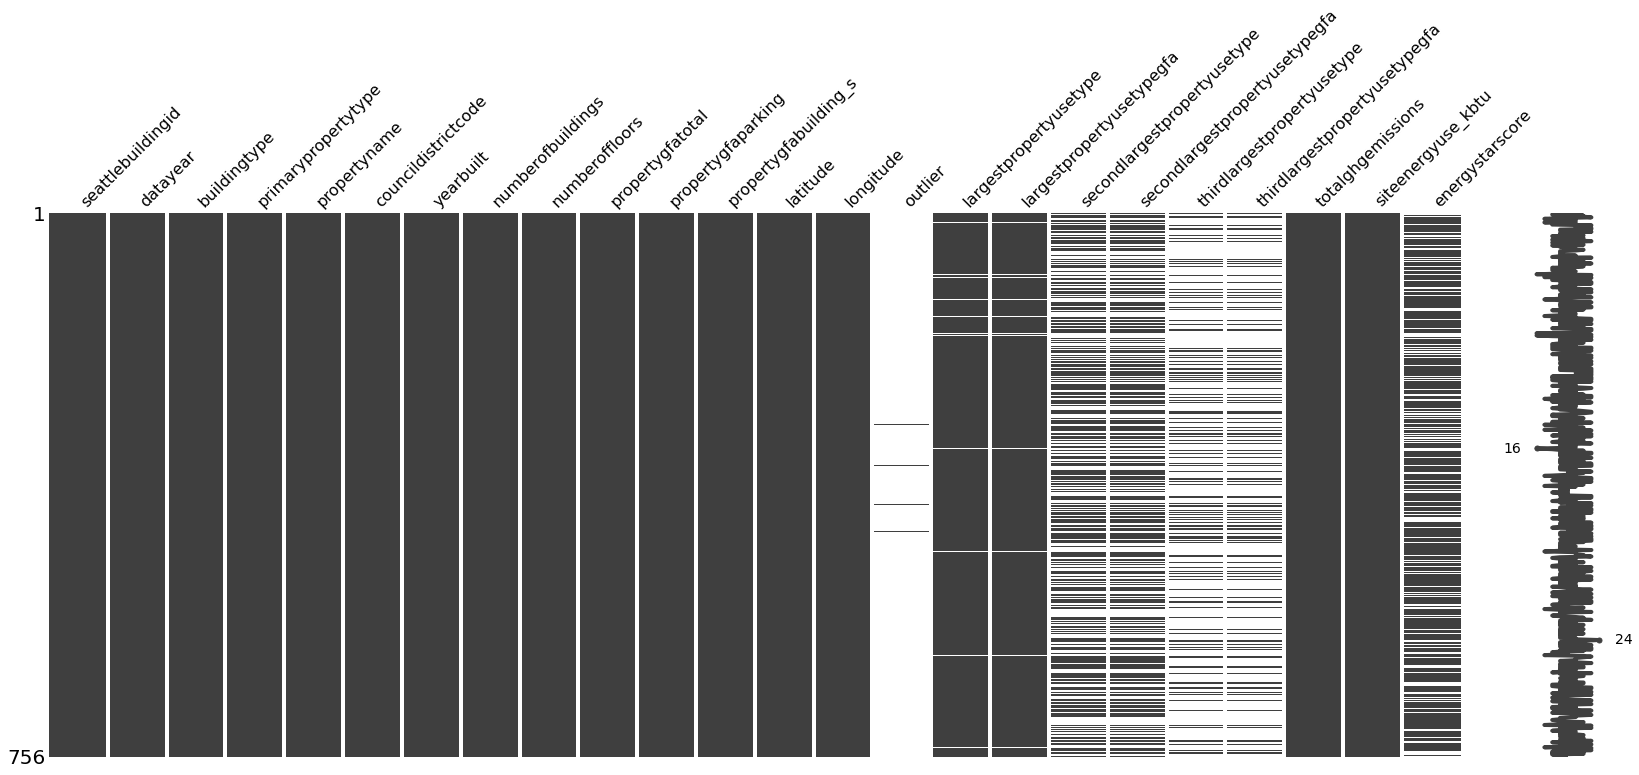

In [ ]:
msno.matrix(data)
plt.show()

## Largest property type

In [ ]:
len(data[data["largestpropertyusetype"].isna()])

19

* 19 Na's in largest

In [ ]:
# mining in error data
error = data[data["largestpropertyusetype"].isna()]
error.head(5)

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
194,314,2015,NonResidential,Hotel,EDGEWATER INN,7,1961,1,4,122309.0,0.0,122309.0,47.61245737,-122.3521832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,977.73,24060332.0,13.00
586,780,2015,NonResidential,Large Office,KING STREET CENTER,2,1998,1,8,446261.0,124788.0,321473.0,47.59885555,-122.330957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.20,13943064.0,97.00
347,488,2015,NonResidential,Mixed Use Property,UW MEDICINE-LK UNION PHASE II & III,7,2008,1,5,436497.0,153684.0,282813.0,47.623959,-122.3405267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.30,41478700.0,NaN
539,725,2015,NonResidential,Distribution Center,OWL TRANSFER,2,1961,1,1,73335.0,0.0,73335.0,47.57022629,-122.3268992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.48,3408500.0,21.00
201,322,2015,NonResidential,Large Office,KIRO RADIO & TELEVISION,7,1968,1,3,100734.0,26731.0,74003.0,47.61744918,-122.35032532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.62,10273140.0,34.00


### Mixed Use Property

In [ ]:
error["primarypropertytype"].unique()

array(['Hotel', 'Large Office', 'Mixed Use Property',
       'Distribution Center', 'Retail Store',
       'Small- and Mid-Sized Office', 'Laboratory', 'Other',
       'Non-Refrigerated Warehouse'], dtype=object)

In [ ]:
error[error["primarypropertytype"] == "Mixed Use Property"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
347,488,2015,NonResidential,Mixed Use Property,UW MEDICINE-LK UNION PHASE II & III,7,2008,1,5,436497.0,153684.0,282813.0,47.623959,-122.3405267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.30,41478700.0,NaN
309,439,2015,NonResidential,Mixed Use Property,FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS,7,2001,1,6,378443.0,177660.0,200783.0,47.61932082,-122.3481439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,474.54,57439532.0,100.00


"UW MEDICINE-LK UNION PHASE II & III" & "FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS"

#### UW MEDICINE

In [ ]:
matching = [s for s in data["propertyname"] if "UW" in s]
matching

['4245 ROOSEVELT - UW MEDICAL CENTER',
 'UW MEDICINE-LK UNION PHASE II & III',
 'THE COLLEGIANA (UW MED)',
 'UW Tower Data Center',
 'UW Tower Bldg Complex']

https://www.washington.edu/news/2011/07/07/third-phase-of-uw-medicine-research-complex-breaks-ground-in-south-lake-union-district/


In [ ]:
data[data["propertyname"] =='4245 ROOSEVELT - UW MEDICAL CENTER']

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
354,495,2015,NonResidential,Medical Office,4245 ROOSEVELT - UW MEDICAL CENTER,4,1994,1,4,191276.0,95281.0,95995.0,47.65884177,-122.3182756,NaN,Medical Office,95995.0,NaN,NaN,NaN,NaN,85.13,9329202.0,16.00


In [ ]:
col = ["propertyname", "latitude",	"longitude"]
data_2015[data_2015["propertyname"] =='4245 ROOSEVELT - UW MEDICAL CENTER'][col]

,propertyname,latitude,longitude
354,4245 ROOSEVELT - UW MEDICAL CENTER,47.65884177,-122.3182756


In [ ]:
data_2015[data_2015["propertyname"] =='UW MEDICINE-LK UNION PHASE II & III'][col]

,propertyname,latitude,longitude
347,UW MEDICINE-LK UNION PHASE II & III,47.623959,-122.3405267


4245 ROOSEVELT - UW MEDICAL CENTER location = UW MEDICINE-LK UNION PHASE II & III

-> "Medical Office"

In [ ]:
data.loc[data["propertyname"] =='UW MEDICINE-LK UNION PHASE II & III',"largestpropertyusetype"]= "Medical Office"

#### FISHER PLAZA

In [ ]:
# looking for other TV building
matching = [s for s in data["propertyname"] if "TV" in s]
matching

['FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS']

In [ ]:
# looking for other TV building
matching = [s for s in data["propertyname"] if "STUDIOS" in s]
matching

['FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS']

In [ ]:
matching = [s for s in data["propertyname"] if "KIRO" in s]
matching

['KIRO RADIO & TELEVISION']

* KIRO is a TV Studio so we will use same type. 

https://www.kiro7.com/


In [ ]:
data[data["propertyname"] == 'KIRO RADIO & TELEVISION']

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
201,322,2015,NonResidential,Large Office,KIRO RADIO & TELEVISION,7,1968,1,3,100734.0,26731.0,74003.0,47.61744918,-122.35032532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.62,10273140.0,34.00


primarypropertytype = Large Office

In [ ]:
data[data["primarypropertytype"] == 'Large Office']["largestpropertyusetype"].unique()

array(['Office', nan], dtype=object)

* Office

In [ ]:
# imputation
data.loc[data["propertyname"] =='FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS',"largestpropertyusetype"]= "Office"

In [ ]:
error = data[data["largestpropertyusetype"].isna()]
error["primarypropertytype"].unique()

array(['Hotel', 'Large Office', 'Distribution Center', 'Retail Store',
       'Small- and Mid-Sized Office', 'Laboratory', 'Other',
       'Non-Refrigerated Warehouse'], dtype=object)

### Other

In [ ]:
# Mining errors
error[error["primarypropertytype"] == 'Other']

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
593,790,2015,NonResidential,Other,PROLOGIS SEATTLE 10 (ROSS DISPLAY),2,1969,1,1,54171.0,0.0,54171.0,47.57289218,-122.3350363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.08,1008645.0,NaN


https://www.prologis.com/industrial-logistics-warehouse-space/americas/united-states/seattle-washington

https://www.rossdisplay.com/

In [ ]:
# imputation
data.loc[data["propertyname"] =='PROLOGIS SEATTLE 10 (ROSS DISPLAY)',"largestpropertyusetype"]= "Warehouse"

In [ ]:
error = data[data["largestpropertyusetype"].isna()]
error["primarypropertytype"].unique()

array(['Hotel', 'Large Office', 'Distribution Center', 'Retail Store',
       'Small- and Mid-Sized Office', 'Laboratory',
       'Non-Refrigerated Warehouse'], dtype=object)

### 1 building

In [ ]:
mask = (data["largestpropertyusetype"].isna()) & (data["numberofbuildings"] == 1)
data.loc[mask,"largestpropertyusetype"] = data.loc[mask,"primarypropertytype"]

In [ ]:
error = data[data["largestpropertyusetype"].isna()]
len(error)

1

In [ ]:
error

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
35,46,2015,NonResidential,Distribution Center,SEATTLE WAREHOUSE OFFICE BUILDING,2,1961,7,2,714095.0,0.0,714095.0,47.5106034,-122.29027588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333.54,47843892.0,1


### SEATTLE WAREHOUSE OFFICE BUILDING

https://www.google.com/maps/place/47%C2%B030'38.2%22N+122%C2%B017'25.0%22W/@47.5136958,-122.2905789,3a,75y,156.43h,89.33t/data=!3m7!1e1!3m5!1smemnsNc7blyJAg76gjbvTg!2e0!6s%2F%2Fgeo0.ggpht.com%2Fmaps%2Fphotothumb%2Ffd%2Fv1%3Fbpb%3DChEKD3NlYXJjaC5nd3MtcHJvZBIgChIJuyeGyEZCkFQR9o214c59AE4qCg0AAAAAFQAAAAAaBAhWEFY%26gl%3DFR!7i16384!8i8192!4m5!3m4!1s0x0:0x0!8m2!3d47.5106034!4d-122.2902759

In [ ]:
data[data["primarypropertytype"]== "Distribution Center"]["largestpropertyusetype"].unique()

array(['Distribution Center', nan], dtype=object)

In [ ]:
# imputation
data.loc[data["seattlebuildingid"] == "46","largestpropertyusetype"] = "Distribution Center"

In [ ]:
data.loc[data["seattlebuildingid"] == "46"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
35,46,2015,NonResidential,Distribution Center,SEATTLE WAREHOUSE OFFICE BUILDING,2,1961,7,2,714095.0,0.0,714095.0,47.5106034,-122.29027588,NaN,Distribution Center,NaN,NaN,NaN,NaN,NaN,333.54,47843892.0,1


In [ ]:
data[data["largestpropertyusetype"].isna()]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore


In [ ]:
error = data[data["largestpropertyusetype"].isna()]
len(error)

0

### NULL

In [ ]:
data[data["largestpropertyusetype"]=="NULL"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,6,1946,2,2,111445.0,0.0,111445.0,47.66838,-122.3931,NaN,NULL,NaN,NULL,NaN,NULL,NaN,163.83,5697472.5,NaN


In [ ]:
matching = [s for s in data["primarypropertytype"] if "Self-Storage Facility" in s]
matching

['Self-Storage Facility',
 'Self-Storage Facility',
 'Self-Storage Facility',
 'Self-Storage Facility',
 'Self-Storage Facility',
 'Self-Storage Facility',
 'Self-Storage Facility\n',
 'Self-Storage Facility']

In [ ]:
data[data["primarypropertytype"] == 'Self-Storage Facility']["largestpropertyusetype"]

244    Self-Storage Facility
127    Self-Storage Facility
142    Self-Storage Facility
42     Self-Storage Facility
382    Self-Storage Facility
34     Self-Storage Facility
353                     NULL
Name: largestpropertyusetype, dtype: object

* Self-Storage Facility primarypropertytype = Self-Storage Facility largestpropertyusetype

In [ ]:
data[data["primarypropertytype"] == 'Self-Storage Facility']["secondlargestpropertyusetype"]

244                  NaN
127                  NaN
142                  NaN
42     Vocational School
382                  NaN
34                   NaN
353                 NULL
Name: secondlargestpropertyusetype, dtype: object

In [ ]:
mask = data["largestpropertyusetype"] == "NULL"
len(data[mask])

1

In [ ]:
data[mask]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,6,1946,2,2,111445.0,0.0,111445.0,47.66838,-122.3931,NaN,NULL,NaN,NULL,NaN,NULL,NaN,163.83,5697472.5,NaN


In [ ]:
# imputation
data.loc[mask,"largestpropertyusetype"] = "Self-Storage Facility"
data.loc[data["largestpropertyusetype"].isna(),"largestpropertyusetype"] = "Self-Storage Facility"
data[data["largestpropertyusetype"].isna()]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore


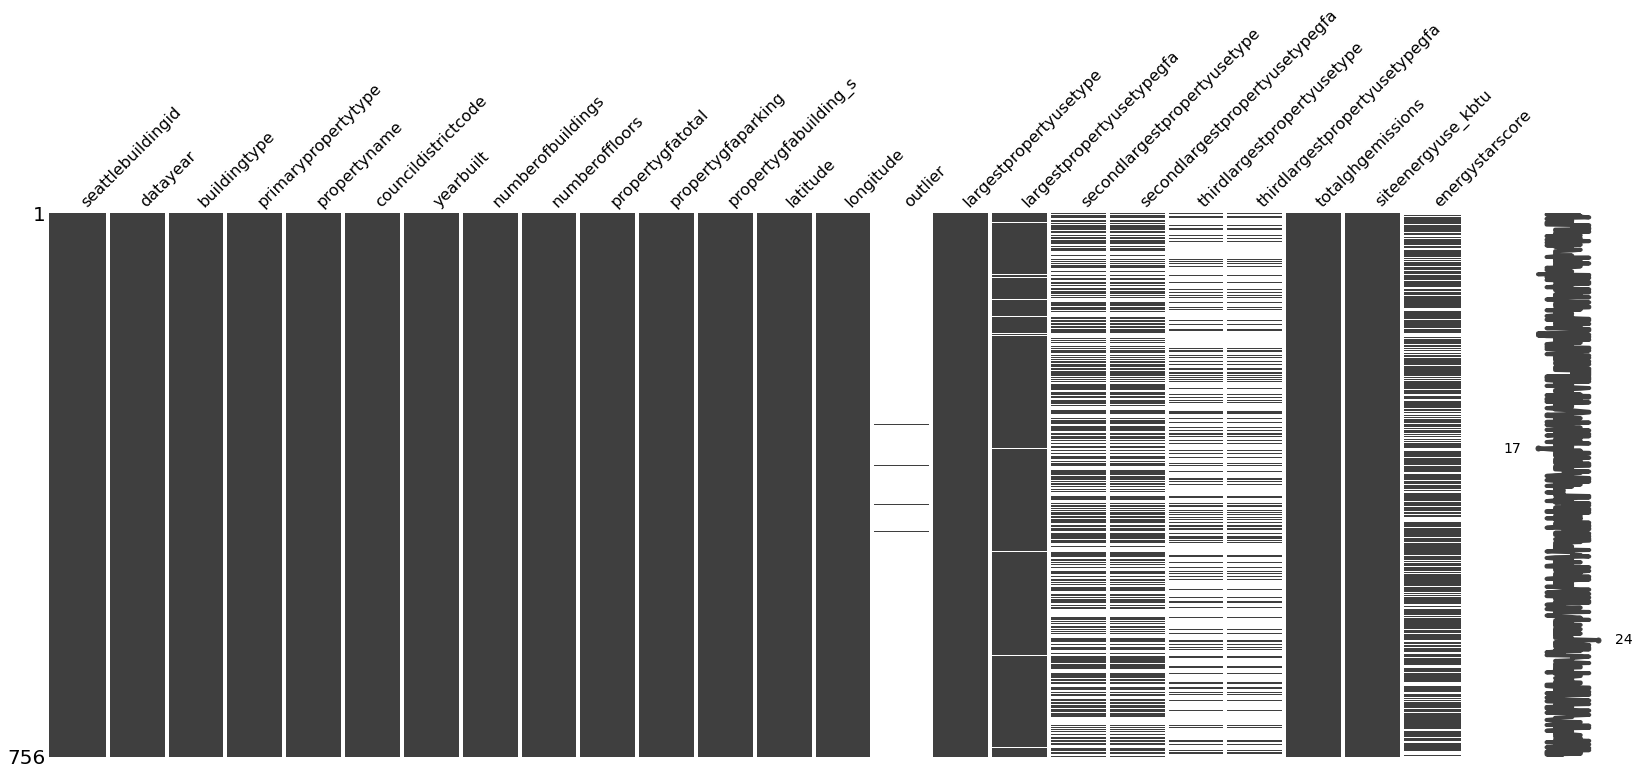

In [ ]:
msno.matrix(data)
plt.show()

## Second largest type

In [ ]:
error = data[data["secondlargestpropertyusetype"].isna()] 
len(error)

334

* 334 na's

In [ ]:
# Mining errors
mask = error["largestpropertyusetypegfa"] == error['propertygfatotal']
error[mask].head(5)

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
456,616,2016,NonResidential,Large Office,(ID616) Court in the Square,2,1907,1,7,160580.0,0.0,160580.0,47.59858,-122.33198,NaN,Office,160580.0,NaN,NaN,NaN,NaN,99.59,4336187.5,98
475,638,2016,NonResidential,Warehouse,West Coast Building,2,1926,1,7,144050.0,0.0,144050.0,47.58365,-122.33467,NaN,Non-Refrigerated Warehouse,144050.0,NaN,NaN,NaN,NaN,98.43,3929371.0,26
88,130,2015,SPS-District K-12,K-12 School,MCCLURE MIDDLE (SPS-DISTRICT),7,1964,1,2,93218.0,0.0,93218.0,47.6367344,-122.3589452,NaN,K-12 School,93218.0,NaN,NaN,NaN,NaN,97.38,3072599.0,84.00
111,178,2016,SPS-District K-12,K-12 School,Van Asselt Elementary,2,2000,1,3,98357.0,0.0,98357.0,47.52915,-122.28904,NaN,K-12 School,98357.0,NaN,NaN,NaN,NaN,94.64,3456131.5,88
325,462,2016,NonResidential,Small- and Mid-Sized Office,Delridge Building,1,1960,1,3,55593.0,0.0,55593.0,47.5671,-122.36416,NaN,Office,55593.0,NaN,NaN,NaN,NaN,93.23,4224872.5,55


### Low-Rise Multifamily

In [ ]:
error["primarypropertytype"].unique()

array(['Large Office', 'Other', 'Warehouse', 'Hotel', 'K-12 School',
       'Retail Store', 'Non-Refrigerated Warehouse',
       'Small- and Mid-Sized Office', 'Distribution Center',
       'Medical Office', 'Worship Facility', 'Hospital',
       'College/University', 'Mixed Use Property', 'University',
       'Residence Hall', 'Laboratory', 'Restaurant',
       'Senior Care Community', 'Self-Storage Facility',
       'Supermarket/Grocery Store', 'Distribution Center\n',
       'Supermarket / Grocery Store', 'Restaurant\n',
       'Low-Rise Multifamily', 'Refrigerated Warehouse'], dtype=object)

In [ ]:
error[error["primarypropertytype"] == 'Low-Rise Multifamily' ]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
644,19445,2016,NonResidential,Low-Rise Multifamily,Pacific Pointe,4,2000,1,3,93079.0,36093.0,56986.0,47.64859,-122.33311,NaN,Multifamily Housing,91064.0,NaN,NaN,NaN,NaN,25.6,1997181.5,32


* No other activities

In [ ]:
# dropping building
index = data[data["primarypropertytype"] == 'Low-Rise Multifamily' ].index
data.drop(index, inplace=True)

### Parking

In [ ]:
mask = error["secondlargestpropertyusetype"].isna() & (error["propertygfaparking"] != 0)
error[mask]["primarypropertytype"].unique()

array(['Large Office', 'Other', 'Medical Office', 'Hotel',
       'Mixed Use Property', 'Small- and Mid-Sized Office', 'Laboratory',
       'Low-Rise Multifamily', 'Retail Store', 'Warehouse',
       'Residence Hall', 'Hospital'], dtype=object)

* No parking in primary

In [ ]:
error[mask]["largestpropertyusetype"].unique()

array(['Large Office', 'Laboratory', 'Medical Office', 'Hotel', 'Office',
       'Small- and Mid-Sized Office', 'Museum', 'Police Station',
       'Multifamily Housing', 'Other', 'Retail Store',
       'Social/Meeting Hall', 'Non-Refrigerated Warehouse',
       'Residence Hall/Dormitory',
       'Hospital (General Medical & Surgical)'], dtype=object)

In [ ]:
error[mask]["thirdlargestpropertyusetype"].unique()

array([nan], dtype=object)

* No third acivities

If there is parking gfa -> second activy is parking

In [ ]:
mask = (data["secondlargestpropertyusetype"].isna()) & (data["propertygfaparking"] != 0) 
data.loc[mask,"secondlargestpropertyusetype"] = "Parking"

### Other

In [ ]:
error[error["primarypropertytype"]=="Other"]["largestpropertyusetype"].unique()

array(['Other', 'Laboratory', 'Automobile Dealership', 'Fire Station',
       'Performing Arts', 'Social/Meeting Hall', 'Financial Office',
       'Strip Mall', 'Museum', 'Other - Entertainment/Public Assembly',
       'Warehouse', 'Police Station', 'Lifestyle Center',
       'Other/Specialty Hospital',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Data Center',
       'Courthouse', 'Manufacturing/Industrial Plant',
       'Other - Education', 'Urgent Care/Clinic/Other Outpatient'],
      dtype=object)

In [ ]:
error[error["primarypropertytype"]=="Other"]["thirdlargestpropertyusetype"].unique()

array([nan], dtype=object)

* No third activity

In [ ]:
mask = (data["secondlargestpropertyusetype"].isna()) & (data["primarypropertytype"]=="Other")
data[mask].head(5)

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
412,566,2015,NonResidential,Other,CENTURYLINK: EAST CO,3,1926,1,3,80004.0,0.0,80004.0,47.61448142,-122.3098028,NaN,Other,74864.0,NaN,NaN,NaN,NaN,99.45,14265421.0,NaN
73,110,2015,Nonresidential COS,Other,EXHIBITION HALL - SEATTLE CENTER,7,1962,1,2,49680.0,0.0,49680.0,47.62393635,-122.35193,NaN,Other,52000.0,NaN,NaN,NaN,NaN,96.39,2632472.0,NaN
436,594,2015,NonResidential,Other,MCKINSTRY SHOP,2,1973,1,1,110689.0,0.0,110689.0,47.5589184,-122.3315553,NaN,Other,110689.0,NaN,NaN,NaN,NaN,92.70,2227640.0,NaN
71,106,2015,Nonresidential COS,Other,ARMORY - SEATTLE CENTER,7,1938,1,5,396085.0,0.0,396085.0,47.62189039,-122.3502752,NaN,Other,278500.0,NaN,NaN,NaN,NaN,900.81,27185096.0,NaN
25,31,2015,NonResidential,Other,SEATTLE HONDA,7,1930,1,2,67224.0,0.0,67224.0,47.61490582,-122.33040102,NaN,Automobile Dealership,67224.0,NaN,NaN,NaN,NaN,9.68,1388717.0,NaN


In [ ]:
len(data[data["largestpropertyusetype"].isna()])

0

* No parking + no third activity = no second activity

### NULL

In [ ]:
data[data["secondlargestpropertyusetype"]=="NULL"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,6,1946,2,2,111445.0,0.0,111445.0,47.66838,-122.3931,NaN,Self-Storage Facility,NaN,NULL,NaN,NULL,NaN,163.83,5697472.5,NaN


In [ ]:
# Imputing
data.loc[data["secondlargestpropertyusetype"]=="NULL", "secondlargestpropertyusetype"] = np.nan


## Third largest type

In [ ]:
error = data[data["thirdlargestpropertyusetype"].isna()]
len(error)

564

### Parking

In [ ]:
mask1 = error["largestpropertyusetype"] != "Parking"
mask2 = error["secondlargestpropertyusetype"] != "Parking"
mask3 = error['propertygfaparking'] != 0

len(error[mask1 & mask2 & mask3])

12

* 12 building with parking gfa, but no parking use in largest and second = parking is third.

In [ ]:
mask1 = (data["largestpropertyusetype"] != "Parking") & (data["secondlargestpropertyusetype"] != "Parking")
mask2 = (data['propertygfaparking'] != 0) & ( data["thirdlargestpropertyusetype"].isna())
len(data[mask1 & mask2])

12

In [ ]:
# impuation 
data.loc[mask1 & mask2,"thirdlargestpropertyusetype"] = "Parking"

### NULL

In [ ]:
data[data["thirdlargestpropertyusetype"]=="NULL"]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
353,496,2016,NonResidential,Self-Storage Facility,Market St Center,6,1946,2,2,111445.0,0.0,111445.0,47.66838,-122.3931,NaN,Self-Storage Facility,NaN,NaN,NaN,NULL,NaN,163.83,5697472.5,NaN


In [ ]:
# imputation
data.loc[data["thirdlargestpropertyusetype"]=="NULL", "thirdlargestpropertyusetype"] = np.nan


In [ ]:
error = data[data["thirdlargestpropertyusetype"].isna()]
len(error)

553

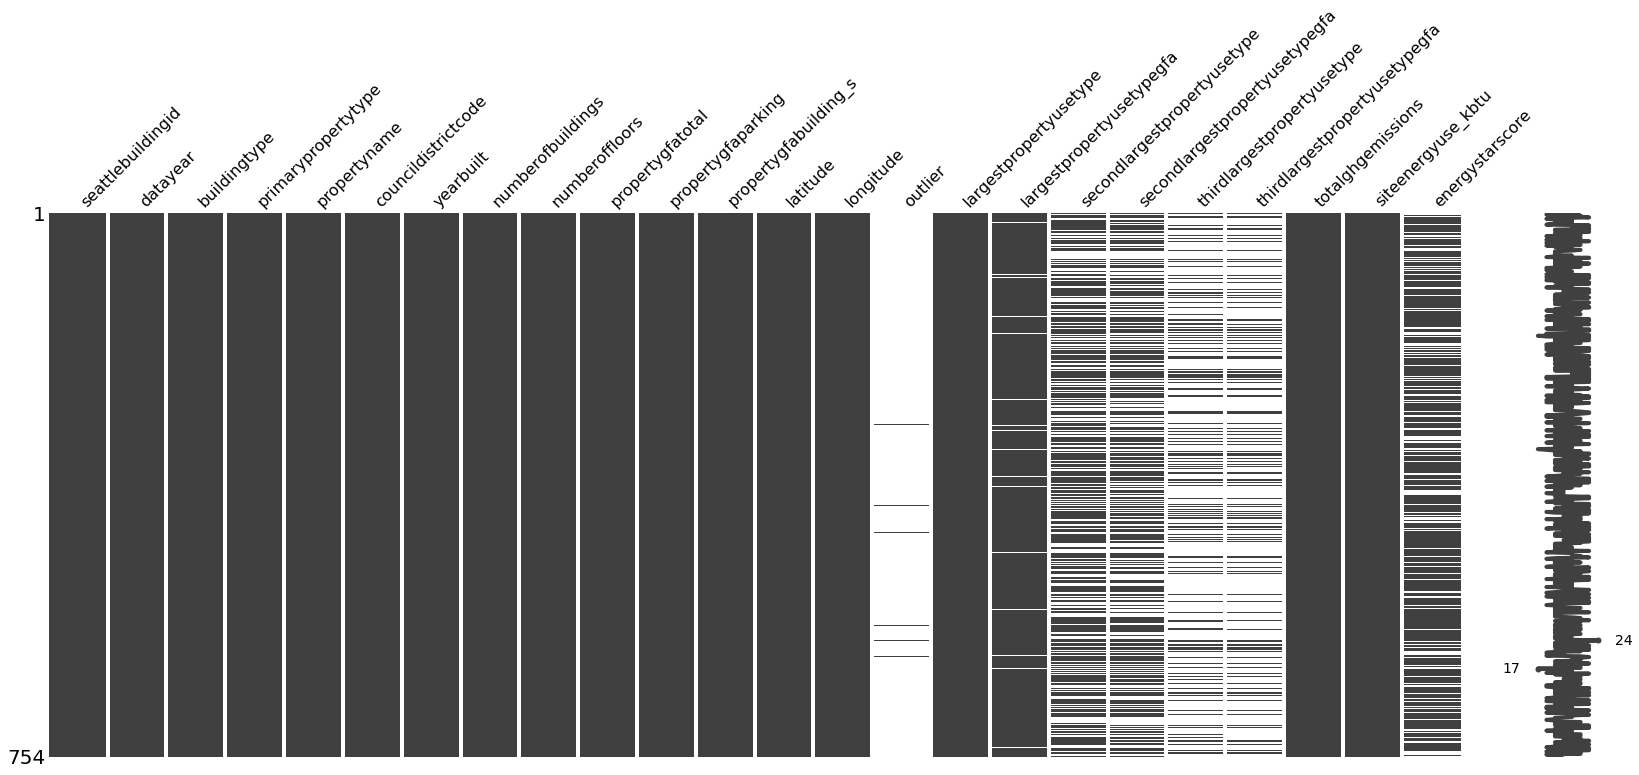

In [ ]:
msno.matrix(data)
plt.show()

In [ ]:
len(data[data["largestpropertyusetype"].isna()])

0

# GFA

## gfa na

If use type = Na -> gfa = 0

In [ ]:
# imputation
data.loc[data['secondlargestpropertyusetype'].isna(),'secondlargestpropertyusetypegfa'] = 0
data.loc[data['thirdlargestpropertyusetype'].isna(),'thirdlargestpropertyusetypegfa'] = 0

## Parking

In [ ]:
# Imputing all parking use types with parking gfa

mask = data['largestpropertyusetype'] == "Parking"
data.loc[mask,'largestpropertyusetypegfa'] = data.loc[mask,'propertygfaparking']


mask = data['secondlargestpropertyusetype'] == "Parking"
data.loc[mask,'secondlargestpropertyusetypegfa'] = data.loc[mask,'propertygfaparking']


mask = data['thirdlargestpropertyusetype'] == "Parking"
data.loc[mask,'thirdlargestpropertyusetypegfa'] = data.loc[mask,'propertygfaparking']



## largest use

In [ ]:
len(data[data['largestpropertyusetypegfa'].isna()])

20

In [ ]:
data[data['largestpropertyusetypegfa'].isna()].head(5)

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
194,314,2015,NonResidential,Hotel,EDGEWATER INN,7,1961,1,4,122309.0,0.0,122309.0,47.61245737,-122.3521832,NaN,Hotel,NaN,NaN,0.0,NaN,0.0,977.73,24060332.0,13.00
586,780,2015,NonResidential,Large Office,KING STREET CENTER,2,1998,1,8,446261.0,124788.0,321473.0,47.59885555,-122.330957,NaN,Large Office,NaN,Parking,124788.0,NaN,0.0,97.20,13943064.0,97.00
347,488,2015,NonResidential,Mixed Use Property,UW MEDICINE-LK UNION PHASE II & III,7,2008,1,5,436497.0,153684.0,282813.0,47.623959,-122.3405267,NaN,Medical Office,NaN,Parking,153684.0,NaN,0.0,798.30,41478700.0,NaN
539,725,2015,NonResidential,Distribution Center,OWL TRANSFER,2,1961,1,1,73335.0,0.0,73335.0,47.57022629,-122.3268992,NaN,Distribution Center,NaN,NaN,0.0,NaN,0.0,78.48,3408500.0,21.00
201,322,2015,NonResidential,Large Office,KIRO RADIO & TELEVISION,7,1968,1,3,100734.0,26731.0,74003.0,47.61744918,-122.35032532,NaN,Large Office,NaN,Parking,26731.0,NaN,0.0,71.62,10273140.0,34.00


### No parking

In [ ]:
mask1 = (data['secondlargestpropertyusetype'].isna()) & (data['thirdlargestpropertyusetype'].isna())
mask2 = data['largestpropertyusetypegfa'].isna() & (data['propertygfaparking'] == 0)
len(data[mask1 & mask2])

12

If no parking and on second or third type, then it's building.

In [ ]:
# imputation
data.loc[mask1 & mask2,'largestpropertyusetypegfa'] = data.loc[mask1 & mask2,'propertygfabuilding_s']

In [ ]:
len(data[data['largestpropertyusetypegfa'].isna()])

8

In [ ]:
data[data['largestpropertyusetypegfa'].isna()]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore
586,780,2015,NonResidential,Large Office,KING STREET CENTER,2,1998,1,8,446261.0,124788.0,321473.0,47.59885555,-122.330957,NaN,Large Office,NaN,Parking,124788.0,NaN,0.0,97.20,13943064.0,97.00
347,488,2015,NonResidential,Mixed Use Property,UW MEDICINE-LK UNION PHASE II & III,7,2008,1,5,436497.0,153684.0,282813.0,47.623959,-122.3405267,NaN,Medical Office,NaN,Parking,153684.0,NaN,0.0,798.30,41478700.0,NaN
201,322,2015,NonResidential,Large Office,KIRO RADIO & TELEVISION,7,1968,1,3,100734.0,26731.0,74003.0,47.61744918,-122.35032532,NaN,Large Office,NaN,Parking,26731.0,NaN,0.0,71.62,10273140.0,34.00
364,513,2015,NonResidential,Small- and Mid-Sized Office,KCPQ,7,1952,1,3,66462.0,12998.0,53464.0,47.63548436,-122.3409248,NaN,Small- and Mid-Sized Office,NaN,Parking,12998.0,NaN,0.0,63.51,9109967.0,NaN
309,439,2015,NonResidential,Mixed Use Property,FISHER PLAZA - EAST BUILDING KOMO-TV STUDIOS,7,2001,1,6,378443.0,177660.0,200783.0,47.61932082,-122.3481439,NaN,Office,NaN,Parking,177660.0,NaN,0.0,474.54,57439532.0,100.00
395,549,2015,NonResidential,Small- and Mid-Sized Office,400 MERCER STREET OFFICE BUILDING,7,1987,1,6,78672.0,28427.0,50245.0,47.62483876,-122.3485262,NaN,Small- and Mid-Sized Office,NaN,Parking,28427.0,NaN,0.0,42.86,2713722.0,95.00
320,453,2015,NonResidential,Small- and Mid-Sized Office,701 DEXTER BUILDING,7,1984,1,6,95721.0,33921.0,61800.0,47.62563138,-122.3428953,NaN,Small- and Mid-Sized Office,NaN,Parking,33921.0,NaN,0.0,21.38,3066228.0,95.00
251,376,2015,NonResidential,Large Office,5TH & BELL BUILDING,7,2002,1,6,287471.0,83591.0,203880.0,47.61605453,-122.34371185,NaN,Large Office,NaN,Parking,83591.0,NaN,0.0,129.21,13010612.0,80.00


### largest = building

In [ ]:
mask1 = (data['secondlargestpropertyusetype'] == "Parking") & (data['thirdlargestpropertyusetype'].isna())
mask2 = data['largestpropertyusetypegfa'].isna() 
len(data[mask1 & mask2])

8

If second is parking and no third type use, then largest = building gfa

In [ ]:
# imputation
data.loc[mask1 & mask2,'largestpropertyusetypegfa'] = data.loc[mask1 & mask2,'propertygfabuilding_s']

In [ ]:
len(data[data['largestpropertyusetypegfa'].isna()])

0

## second largest use

In [ ]:
len(data[data['secondlargestpropertyusetypegfa'].isna()])

0

## third largest use

In [ ]:
len(data[data['thirdlargestpropertyusetypegfa'].isna()])

0

# Outliers


## Total gfa

In [ ]:
mask = (data['propertygfatotal'] != (data["propertygfaparking"] +
                                     data["propertygfabuilding_s"] ))
len(data[mask])

0

* No errors in total gfa

In [ ]:
data["filled"] = (data["largestpropertyusetypegfa"].fillna(0) +
                                     data["secondlargestpropertyusetypegfa"].fillna(0) +
                                     data["thirdlargestpropertyusetypegfa"].fillna(0) )

mask = (data['propertygfatotal'] != data["filled"])
len(data[mask])

482

* Errors in data ?

10% marge sup

In [ ]:
mask = (data['propertygfatotal'] < ((data["largestpropertyusetypegfa"].fillna(0) +
                                     data["secondlargestpropertyusetypegfa"].fillna(0) +
                                     data["thirdlargestpropertyusetypegfa"].fillna(0) ))*1.1)
len(data[mask])

650

In [ ]:
len(data[mask])/len(data)

0.8620689655172413

10% marge sup

In [ ]:
mask = (data['propertygfatotal'] > ((data["largestpropertyusetypegfa"].fillna(0) +
                                     data["secondlargestpropertyusetypegfa"].fillna(0) +
                                     data["thirdlargestpropertyusetypegfa"].fillna(0) ))*0.9)
len(data[mask])

682

In [ ]:
len(data[mask])/len(data)

0.9045092838196287

* 86-90% of data are within 10% margin.

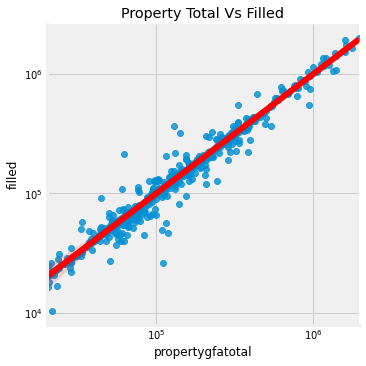

In [ ]:
sns.lmplot(x='propertygfatotal', y ="filled",
            data=data,
           line_kws = {"color": "red"})
plt.yscale("log")
plt.xscale("log")
plt.title("Property Total Vs Filled")
plt.show()

In [ ]:
subset = data[["filled","propertygfatotal"]]
subset.corr()

,filled,propertygfatotal
filled,1.000000,0.985713
propertygfatotal,0.985713,1.000000


* High correlation

## OUTLIERS variable

In [ ]:
data["outlier"] = data["outlier"].str.lower()
data["outlier"] = data["outlier"].fillna("No")

<Figure size 1008x576 with 0 Axes>

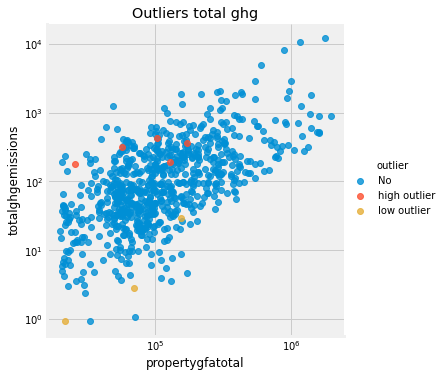

In [ ]:
plt.figure(figsize=(14,8))
sns.lmplot(x="propertygfatotal", y = "totalghgemissions", hue = "outlier", data=data, fit_reg=False)
plt.yscale("log")
plt.xscale("log")
plt.title("Outliers total ghg")
plt.show()

<Figure size 1008x576 with 0 Axes>

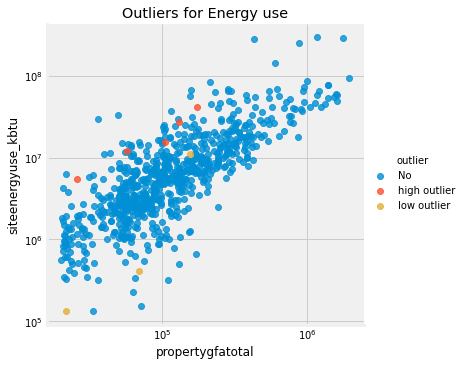

In [ ]:
plt.figure(figsize=(14,8))
sns.lmplot(x="propertygfatotal", y = "siteenergyuse_kbtu", hue = "outlier", data=data, fit_reg=False)
plt.yscale("log")
plt.xscale("log")
plt.title("Outliers for Energy use")
plt.show()

* No real use of outlier variable.

# KTBU = 0

In [ ]:
len(data[data['siteenergyuse_kbtu']== 0])

7

* 7 building with 0 KTBU.

In [ ]:
data[data['siteenergyuse_kbtu']== 0]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore,filled
630,850,2016,SPS-District K-12,K-12 School,Leschi Elementary,3,1988,1,3,55353.0,0.0,55353.0,47.6021,-122.29181,No,K-12 School,55353.0,NaN,0.0,NaN,0.0,9.99,0.0,NaN,55353.0
62,87,2016,SPS-District K-12,K-12 School,Arbor Heights Elementary,1,1948,1,2,53352.0,0.0,53352.0,47.5097,-122.37759,No,K-12 School,65568.0,NaN,0.0,NaN,0.0,4.19,0.0,NaN,65568.0
133,217,2016,SPS-District K-12,K-12 School,Whitman Middle,6,1959,1,1,160270.0,0.0,160270.0,47.69675,-122.3776,No,K-12 School,160270.0,NaN,0.0,NaN,0.0,229.38,0.0,NaN,160270.0
85,122,2016,SPS-District K-12,K-12 School,John Muir Elementary,2,1991,1,2,58933.0,0.0,58933.0,47.57324,-122.29058,No,K-12 School,60725.0,NaN,0.0,NaN,0.0,16.36,0.0,NaN,60725.0
95,140,2016,SPS-District K-12,K-12 School,B.F. Day Elementary,6,1991,1,3,66588.0,0.0,66588.0,47.65464,-122.34912,No,K-12 School,66588.0,NaN,0.0,NaN,0.0,14.67,0.0,NaN,66588.0
614,820,2016,SPS-District K-12,K-12 School,Bailey Gatzert Elementary,3,1988,1,1,52924.0,0.0,52924.0,47.6012,-122.31548,No,K-12 School,52924.0,NaN,0.0,NaN,0.0,13.64,0.0,NaN,52924.0
31,37,2016,SPS-District K-12,K-12 School,John Hay Elementary,7,1989,1,2,51582.0,0.0,51582.0,47.6329,-122.35172,No,K-12 School,55166.0,NaN,0.0,NaN,0.0,10.43,0.0,NaN,55166.0


* All K-12 Schools !

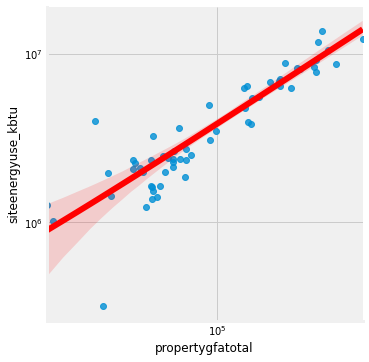

In [ ]:
# is there a relationship totalgfa and kbtu ?
error = data[data['largestpropertyusetype']== "K-12 School"]
error = error[error['siteenergyuse_kbtu']!= 0]

sns.lmplot(x='propertygfatotal', y ="siteenergyuse_kbtu",
            data=error,
           line_kws = {"color": "red"})
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
subset = error[["siteenergyuse_kbtu","propertygfatotal"]]
subset.corr()

,siteenergyuse_kbtu,propertygfatotal
siteenergyuse_kbtu,1.000000,0.944392
propertygfatotal,0.944392,1.000000


* Yes. The we will impute base on average ktbu per gfa for K-12 Schools.

In [ ]:
temp = data[data['largestpropertyusetype']== "K-12 School"]
kbtu_per_gfa = temp.siteenergyuse_kbtu / temp.propertygfatotal

# Imputation

mask = data['siteenergyuse_kbtu']== 0
data.loc[mask,'siteenergyuse_kbtu'] = data.loc[mask]['propertygfatotal'] * (kbtu_per_gfa.median())

In [ ]:
len(data[data['siteenergyuse_kbtu']== 0])

0

# GHG = 0

In [ ]:
len(data[data['totalghgemissions']== 0])

0

# largestpropertyusetypegfa = 0

In [ ]:
len(data[data['largestpropertyusetypegfa']== 0]) 

0

In [ ]:
data[data['largestpropertyusetypegfa']== 0]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore,filled


# buildingtype

In [ ]:
print("Type nb: " + str(len(data.primarypropertytype.unique())))
print(data.primarypropertytype.unique())

Type nb: 27
['Other' 'Large Office' 'Small- and Mid-Sized Office'
 'Distribution Center\n' 'Warehouse' 'Hotel' 'K-12 School' 'Retail Store'
 'Restaurant\n' 'Non-Refrigerated Warehouse' 'Mixed Use Property'
 'Medical Office' 'Restaurant' 'University' 'Residence Hall'
 'Distribution Center' 'Worship Facility' 'Hospital' 'College/University'
 'Laboratory' 'Senior Care Community' 'Self-Storage Facility'
 'Supermarket/Grocery Store' 'Supermarket / Grocery Store'
 'Self-Storage Facility\n' 'Refrigerated Warehouse'
 'Residence Hall/Dormitory']


## Dorms

* Dorms are residential buildings.

In [ ]:
to_drop = ['Residence Hall/Dormitory','Residence Hall']

len(data[data["primarypropertytype"].isin(to_drop)])

6

In [ ]:
# dropping dorms
index = data[data["primarypropertytype"].isin(to_drop)].index
data.drop(index, inplace=True)

data[data["primarypropertytype"].isin(to_drop)]

,seattlebuildingid,datayear,buildingtype,primarypropertytype,propertyname,councildistrictcode,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuilding_s,latitude,longitude,outlier,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,totalghgemissions,siteenergyuse_kbtu,energystarscore,filled


# Largest Use type family

In [ ]:
print("Type nb: " + str(len(data.largestpropertyusetype.unique())))
print(data.largestpropertyusetype.unique())

Type nb: 48
['Other' 'Office' 'Parking' 'Distribution Center'
 'Non-Refrigerated Warehouse' 'Hotel' 'K-12 School' 'Large Office'
 'Laboratory' 'Retail Store' 'Restaurant' 'Multifamily Housing'
 'Medical Office' 'Automobile Dealership' 'College/University'
 'Other - Entertainment/Public Assembly' 'Fire Station' 'Worship Facility'
 'Financial Office' 'Hospital (General Medical & Surgical)'
 'Performing Arts' 'Small- and Mid-Sized Office' 'Social/Meeting Hall'
 'Senior Care Community' 'Self-Storage Facility' 'Strip Mall' 'Museum'
 'Supermarket/Grocery Store' 'Fitness Center/Health Club/Gym' 'Warehouse'
 'Other - Mall' 'Other - Recreation' 'Police Station' 'Lifestyle Center'
 'Other/Specialty Hospital' 'Wholesale Club/Supercenter'
 'Repair Services (Vehicle, Shoe, Locksmith, etc)'
 'Refrigerated Warehouse' 'Data Center' 'Library' 'Convention Center'
 'Other - Public Services' 'Courthouse' 'Manufacturing/Industrial Plant'
 'Other - Education' 'Urgent Care/Clinic/Other Outpatient'
 'Other - 

#primarypropertytype

In [ ]:
data["primarypropertytype"].unique()

array(['Other', 'Large Office', 'Small- and Mid-Sized Office',
       'Distribution Center\n', 'Warehouse', 'Hotel', 'K-12 School',
       'Retail Store', 'Restaurant\n', 'Non-Refrigerated Warehouse',
       'Mixed Use Property', 'Medical Office', 'Restaurant', 'University',
       'Distribution Center', 'Worship Facility', 'Hospital',
       'College/University', 'Laboratory', 'Senior Care Community',
       'Self-Storage Facility', 'Supermarket/Grocery Store',
       'Supermarket / Grocery Store', 'Self-Storage Facility\n',
       'Refrigerated Warehouse'], dtype=object)

## Distribution Center\n

In [ ]:
# correcting text
data.loc[data["primarypropertytype"] == "Distribution Center\n", "primarypropertytype"] = "Distribution Center"

## Super market

In [ ]:
# correcting text
data.loc[data["primarypropertytype"] == "Supermarket/Grocery Store", "primarypropertytype"] = "Supermarket / Grocery Store"

## Restaurant

In [ ]:
# Correcting text
data.loc[data["primarypropertytype"] == "Restaurant\n", "primarypropertytype"] = "Restaurant"

## Storage / warehouse

In [ ]:
# listing Self-Storage
storage = [s for s in data["primarypropertytype"] if "Storage" in s]

def unique(list1): 
    x = np.array(list1) 
    print(np.unique(x))
    
unique(storage)

['Self-Storage Facility' 'Self-Storage Facility\n']


In [ ]:
# correcting text
mask = data["primarypropertytype"].isin(storage)

data.loc[mask , "primarypropertytype"] = "Self-Storage Facility"

## College/University 

In [ ]:
# correcting text
mask = (data["primarypropertytype"] == "University")

data.loc[mask , "primarypropertytype"] = "College/University"

# largest type

In [ ]:
data['largestpropertyusetype'].value_counts()

Office                                             266
Non-Refrigerated Warehouse                          71
K-12 School                                         65
Hotel                                               60
Retail Store                                        50
Other                                               40
Distribution Center                                 27
Medical Office                                      24
Worship Facility                                    16
Parking                                             15
Other - Entertainment/Public Assembly               10
Supermarket/Grocery Store                            9
Self-Storage Facility                                8
College/University                                   8
Laboratory                                           7
Hospital (General Medical & Surgical)                6
Restaurant                                           6
Senior Care Community                                5
Social/Mee

# second largest type

In [ ]:
data['secondlargestpropertyusetype'].unique()

array(['Distribution Center', nan, 'Parking', 'Retail Store', 'Office',
       'Multifamily Housing', 'Other - Recreation', 'Laboratory',
       'Supermarket/Grocery Store', 'Other', 'Restaurant',
       'Medical Office', 'Other - Education', 'Bank Branch',
       'Fitness Center/Health Club/Gym',
       'Convenience Store without Gas Station',
       'Non-Refrigerated Warehouse', 'Data Center', 'Adult Education',
       'Manufacturing/Industrial Plant', 'Vocational School',
       'K-12 School', 'Courthouse', 'Other - Lodging/Residential',
       'Residence Hall/Dormitory', 'Other - Services', 'Performing Arts',
       'Bar/Nightclub', 'Other - Entertainment/Public Assembly',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Self-Storage Facility',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'College/University', 'Swimming Pool', 'Financial Office',
       'Movie Theater'], dtype=object)

# third largest type

In [ ]:
data['thirdlargestpropertyusetype'].unique()

array(['Office', nan, 'Other', 'Parking', 'Non-Refrigerated Warehouse',
       'Restaurant', 'Retail Store', 'Data Center', 'Multifamily Housing',
       'Medical Office', 'Bank Branch', 'Other - Restaurant/Bar',
       'Other - Entertainment/Public Assembly', 'Hotel', 'Food Service',
       'Other - Recreation', 'Laboratory', 'Other - Technology/Science',
       'Fitness Center/Health Club/Gym', 'Other - Services',
       'Social/Meeting Hall', 'Swimming Pool', 'Financial Office',
       'Refrigerated Warehouse',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Distribution Center', 'K-12 School', 'Pre-school/Daycare',
       'Self-Storage Facility', 'Convenience Store without Gas Station',
       'Other - Education'], dtype=object)

In [ ]:
# Dropping filled 
data.drop("filled", axis = 1 , inplace=True)

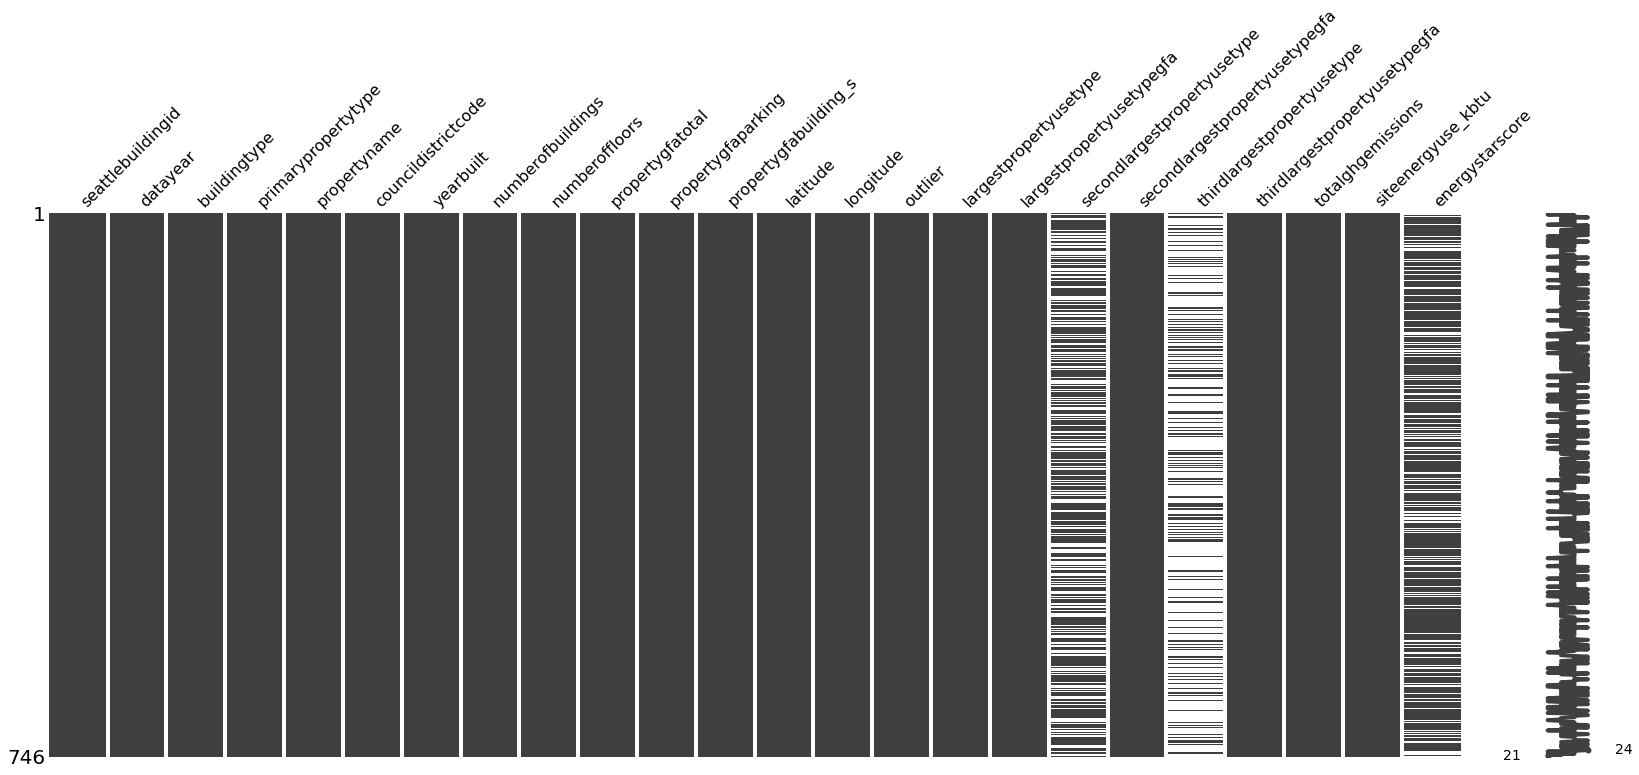

In [ ]:
msno.matrix(data)
plt.show()

# Final DF

In [ ]:
# Saving final dataframe

data.to_csv("/content/drive/My Drive/DATASETS/ML/P3/data.csv", index=False)